# ARIMA Model For Port of LA

**Reading Data File**

There are two datasets provided
1. **The LAbike dataset** had 639786 unique trip details with 13 attributes pertaining to start and end
station IDs with their co-ordinates, start and end times, pass holder type and trip category
whether one way or round trip.
2. **Stations_Table dataset** provides the details of each 143 stations with their unique Station IDs,
station names and their Go Live Date.

In [5]:
import pandas as pd
import numpy as np

df=pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/LABikeData.xlsx')
df2 = pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/Station_Table.xlsx')

In [6]:
df.isna().sum()

trip_id                    0
bike_id                    0
start_station              0
end_station            43198
trip_route_category        0
start_time                 0
end_time                   0
start_lat               1354
start_lon               1354
end_lat                 9110
end_lon                 9110
plan_duration            384
passholder_type            0
dtype: int64

In [7]:
#For some station Start latitude is zeroso removing it
df=df[df['start_lat']!=0]
df.describe()
df.columns
df.start_station.nunique()
df2.Station_ID.nunique()

143

In [8]:
#Merging the two datasets on station id's
df3=df.set_index('start_station').join(df2.set_index('Station_ID'))

**Resampling** : We resampled the data to have number of trips on a particular day for every year

In [9]:
df4 = df3.loc[:,('start_time','Region', 'trip_id')]
df4['start_time'] = pd.to_datetime(df4.start_time, format = '%d/%m/%Y %I:%M:%S %p' )
df4
df4['Day'] = df4.start_time.dt.dayofweek
df4['Date'] = df4.start_time.dt.day
df4['Month'] = df4.start_time.dt.month
df4['Hour'] = df4.start_time.dt.hour
df4['Year'] = df4.start_time.dt.year
df4.groupby(['Day','Year'])['trip_id'].count()

Day  Year
0    2016    12909
     2017    30885
     2018    43745
1    2016    14296
     2017    32861
     2018    45127
2    2016    14480
     2017    33492
     2018    43563
3    2016    15230
     2017    33580
     2018    44024
4    2016    15256
     2017    34744
     2018    46019
5    2016    13498
     2017    32493
     2018    44546
6    2016    12936
     2017    31200
     2018    44870
Name: trip_id, dtype: int64

Converting our data in time series format which will then be used to fit ARIMA model

In [10]:
Data_PLA= df4.loc[df4['Region']=='Port of LA',:]
Data_PLA.index = Data_PLA.start_time
Data_PLA_D = Data_PLA.resample('D').count()
Data_PLA_D = Data_PLA_D.rename(columns={'Region':'trips'})
Data_PLA_D=Data_PLA_D.drop(Data_PLA_D.columns[[0,2,3,4,5,6,7]],axis=1)
Data_PLA_D


,trips
start_time,
2017-07-18,7
2017-07-19,15
2017-07-20,14
2017-07-21,0
2017-07-22,0
2017-07-23,0
2017-07-24,0
2017-07-25,0
2017-07-26,0


**Data Partition**

Text(0, 0.5, 'Number of trips')

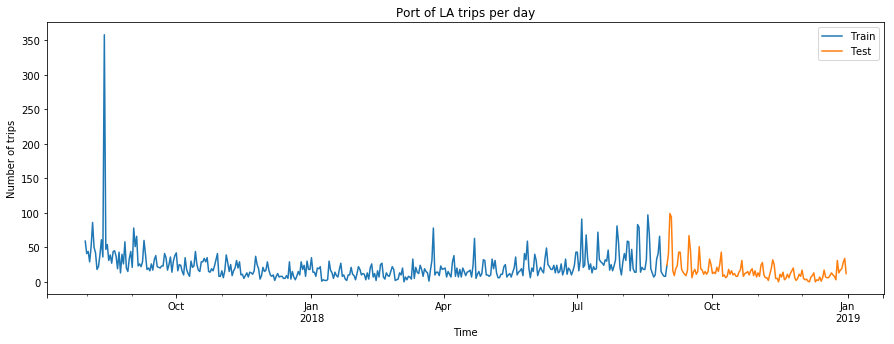

In [23]:
import matplotlib.pyplot as plt
train_PLA = Data_PLA_D.loc['2017-07-31':'2018-08-31']
test_PLA = Data_PLA_D.loc['2018-08-31':]
train_PLA.shape,test_PLA.shape
train_PLA.trips.plot(label = 'Train')
a=test_PLA.trips.plot(label="Test", figsize = (15,5))

plt.legend()
plt.title('Port of LA trips per day')
plt.xlabel('Time')
plt.ylabel('Number of trips')



An ARIMA model is characterized by 3 terms: p, d, q
where,
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.
P, D & Q represents the same parameters ut for seasonal component.

Here we have used grid search method to iterate for various values of the parameters and checked the AIC value for each combination of parameters. The one which give lowest AIC value is the optimal combination of parameter which we used in fitting our model

In [15]:
import itertools
#Defining parameters p, d, q to take value from 0 to 2
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq=list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 28) for x in list(itertools.product(p, d, q))]

In [ ]:
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages
arr=[]
min_aic = 1e64
for param in pdq:
 for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_PLA,
                                            order=param,
                                            seasonal_order=param_seasonal, enforce_invertibility=False,
                                            enforce_stationarity=False
                                            )

            results = mod.fit()
            arr.append(results.aic)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                best_param,best_param_seasonal = param, param_seasonal

In [ ]:
The best model is obtained by choosing ARIMA(1,0,1)(1,1,2)28.

**Model Fitting**

In [24]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
mod = sm.tsa.statespace.SARIMAX(train_PLA,
                                order=(1,0,1),
                                seasonal_order=(1, 1, 2, 28),
                                enforce_invertibility=False,
                               enforce_stationarity=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9806      0.012     81.774      0.000       0.957       1.004
ma.L1         -0.8915      0.035    -25.629      0.000      -0.960      -0.823
ar.S.L28      -0.1566      0.059     -2.668      0.008      -0.272      -0.042
ma.S.L28      -0.5537      0.086     -6.461      0.000      -0.722      -0.386
ma.S.L56      -0.2616      0.069     -3.765      0.000      -0.398      -0.125
sigma2       147.5174      7.530     19.590      0.000     132.758     162.277


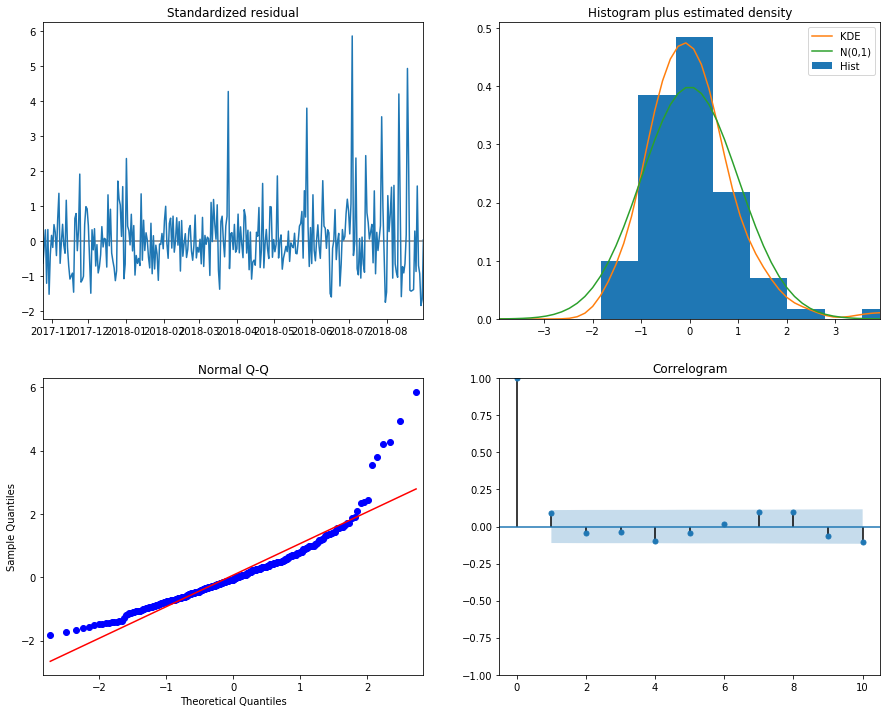

In [25]:
# Residual Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Validation**

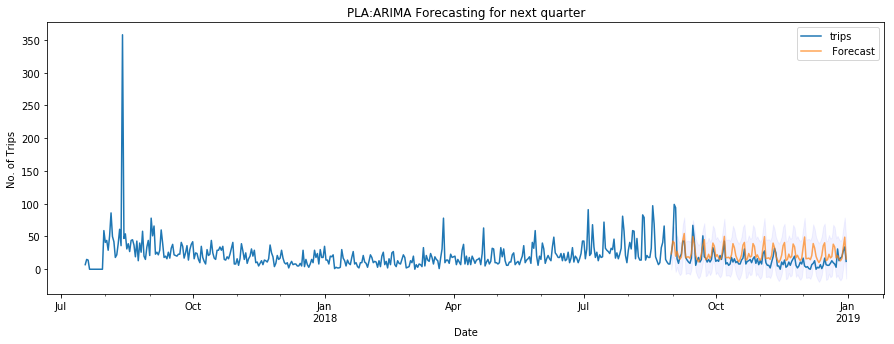

In [28]:
pred = results.get_prediction(start='2018-08-31', end='2018-12-31', dynamic=False)
pred_ci = pred.conf_int()
ax=Data_PLA_D.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label=' Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='b', alpha=0.05)


ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("PLA:ARIMA Forecasting for next quarter")
plt.legend()


**Predricting the trips for next quarter using this model**

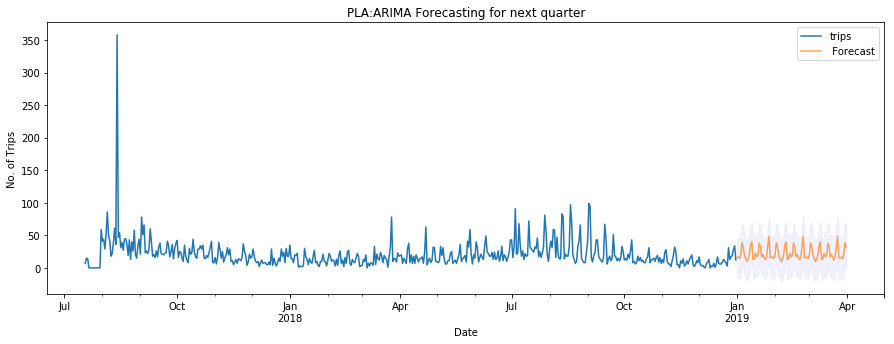

In [29]:
pred1 = results.get_prediction(start='2019-01-01', end='2019-03-31', dynamic=False)
pred1_ci = pred1.conf_int()
ax=Data_PLA_D.plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label=' Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='b', alpha=0.05)


ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("PLA:ARIMA Forecasting for next quarter")
plt.legend()

In [30]:
y_truth = test_PLA #Actual number of trips for validation data
y_forecasted = pred.predicted_mean #Predicted number of trips for validation data
y_future= pred1.predicted_mean #predicted  number of trips for next  quarter

Exporting this data file in Microsoft Excel to further analyze them.

In [32]:
y_truth.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/PLAtruth.xlsx')
y_forecasted.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/PLAforecast.xlsx')
y_future.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/PLAfuture.xlsx')